In [1]:
# %cd gestures/
!ls

LSFB-tries
Mediapipe_test.ipynb
__pycache__
arcface.py
asl-sign-detection-pytorch-lightning.ipynb
autsl-custom-try.ipynb
data
ds.py
ds_preprocess.ipynb
fit-profiler_logs.txt
gest.zip
gestures
graphs
mediapipe_swin_arcface.ipynb
models
mp_swint_arcface_128emb.ckpt
mp_swint_arcface_128emb_loss_weight.ckpt
mp_swint_arcface_64emb.ckpt
mp_swint_arcface_64emb_loss_weight.ckpt
pizdec.ipynb
pl_mp_swint_arcface_128emb.ckpt
pl_mp_swint_arcface_64emb.ckpt
prof_logs
requirements.txt
swin_arcface.ipynb
test_conf_mat.png
train_conf_mat.png
validate-profiler_logs.txt
wandb


In [2]:
# pip list

In [3]:
%%time
from tqdm.notebook import tqdm
import torch
from torch import nn, optim
from torch.nn import functional as F
from matplotlib import pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torch.utils.data import DataLoader, random_split, Dataset
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from arcface import ArcFaceLoss
import graphviz
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy, MulticlassConfusionMatrix
import torchvision
import json
import pandas as pd
from torchmetrics import MetricCollection
import os
import seaborn as sns
import torchvision.transforms.v2 as tf
from ds import VideoFrameDataset, ImglistToTensor
from torchvision.models.video.swin_transformer import swin3d_b, Swin3D_B_Weights
from torchvision.models.video.swin_transformer import swin3d_t, Swin3D_T_Weights


from pytorch_lightning.callbacks import LearningRateMonitor
torch.set_float32_matmul_precision("medium")

from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM

CPU times: user 5.99 s, sys: 897 ms, total: 6.89 s
Wall time: 40.9 s


/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [4]:
# pip freeze > requirements.txt

In [5]:
# import warnings
# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

In [6]:
# torch.cuda.empty_cache()
print(torch.cuda.list_gpu_processes())

GPU:0
process    2893077 uses     2176.000 MB GPU memory


### Dataset

In [7]:
MODEL_INPUT_SIZE = 200

class NpToTensor(torch.nn.Module):
    @staticmethod
    def forward(img_list):
        return (torch.tensor(img_list.transpose(0, 3, 1, 2)).float() / 255)

In [8]:
ds_path = 'data/autsl_frames'
train_ds = torchvision.datasets.DatasetFolder(
                    root=f'data/autsl_np16/train',
                    loader=np.load,
                    transform= NpToTensor(),
                    extensions=('.npy'), )
# VideoFrameDataset(
#     'data/autsl_frames/train',
#     'data/autsl_frames/train/annotations.txt',
#     8,
#     1,
#     imagefile_template= 'img_{:04d}.jpg',
#     transform=frame_transforms['train']
# )

val_ds = torchvision.datasets.DatasetFolder(
                    root=f'data/autsl_np16/val',
                    loader=np.load,
                    transform= NpToTensor(),
                    extensions=('.npy'), )
# VideoFrameDataset(
#     'data/autsl_frames/val',
#     'data/autsl_frames/val/annotations.txt',
#     8,
#     1,
#     imagefile_template= 'img_{:04d}.jpg',
#     transform=frame_transforms['val']
# )

test_ds = torchvision.datasets.DatasetFolder(
                    root=f'data/autsl_np16/test',
                    loader=np.load,
                    transform= NpToTensor(),
                    extensions=('.npy'), )

In [9]:
eval_ds = torchvision.datasets.DatasetFolder(
                    root=f'data/autsl_np16/test',
                    loader=np.load,
                    transform= NpToTensor(),
                    extensions=('.npy'), )

In [10]:
len(train_ds), len(val_ds), len(test_ds)

(28142, 4418, 3742)

In [11]:
train_samples = [s for s in train_ds.samples if s[1] < 200]
train_ds.samples = train_samples
val_samples = [s for s in val_ds.samples if s[1] < 200]
val_ds.samples = val_samples
test_samples = [s for s in test_ds.samples if s[1] < 200]
test_ds.samples = test_samples
eval_samples = [s for s in eval_ds.samples if s[1] >= 200]
eval_ds.samples = eval_samples

In [12]:
train_ds = torch.utils.data.ConcatDataset([train_ds, val_ds])
len(train_ds)

28840

In [13]:
def batch_as_list_collate(batch_samples):
    return batch_samples

train_loader = DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=8, drop_last=True, pin_memory=False)#, collate_fn=batch_as_list_collate)
# val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=8, pin_memory=False)#, collate_fn=batch_as_list_collate)
test_loader = DataLoader(test_ds, batch_size=12, shuffle=False, num_workers=8, pin_memory=False)#, collate_fn=batch_as_list_collate)

### Model

In [14]:
EMB_SIZE = 8

In [18]:
class SwinTransformer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = swin3d_t(weights=Swin3D_T_Weights.DEFAULT)
        self.model.head = nn.Linear(in_features=768, out_features=num_classes, bias=True)

    def forward(self, X):
        return self.model(X)

In [19]:
class LITModule(pl.LightningModule):
    def __init__(
        self,
        emb_dim: float,
        drop_rate: float,
        eta_min: float,
        learning_rate: float,
        loss: str,
        num_classes: int,
        optimizer: str,
        scheduler: str,
        weight_decay: float,
        pretrained_path: str = None,
        pretrained_frame_encoder_path: str = None
    ):
        super().__init__()

        self.save_hyperparameters()

        self.model = self._init_model(pretrained_path, pretrained_frame_encoder_path)

        self.loss_fn = self._init_loss_fn()

        self.metrics = self._init_metrics()
        
        self.transforms = self._init_transforms()

    def _init_model(self, pretrained_path=None, pretrained_frame_encoder_path=None):
        if pretrained_path is not None:
            return torch.load(pretrained_path)
        
        # model = VideoClassifier(
        #         emb_dim=self.hparams.emb_dim,
        #         num_classes=self.hparams.num_classes,
        #     )
        
        model = SwinTransformer(
            num_classes=self.hparams.num_classes)
        
        if pretrained_frame_encoder_path is not None:
            model.frame_enc = torch.load(pretrained_frame_encoder_path)
            
        return model
            

    def _init_loss_fn(self):
        if self.hparams.loss == "Arcface":
            loss = ArcFaceLoss(in_features=EMB_SIZE, num_classes=self.hparams.num_classes)
            if self.model.model.head.in_features != EMB_SIZE:
                self.model.model.head = nn.Linear(768, EMB_SIZE)
            return loss
            
        else:
            raise ValueError(f"{self.hparams.loss} is not a valid loss function")

    def _init_metrics(self):
        metrics = {
                   # 'rocauc': MulticlassAUROC(self.hparams.num_classes),
                   'acc@1' : MulticlassAccuracy(self.hparams.num_classes, top_k=1),
                   'acc@5' : MulticlassAccuracy(self.hparams.num_classes, top_k=5),
                   'acc@10': MulticlassAccuracy(self.hparams.num_classes, top_k=10),
        }
        metric_collection = MetricCollection(metrics)

        return torch.nn.ModuleDict(
            {
                "train_metrics": metric_collection.clone(prefix="train_"),
                "val_metrics": metric_collection.clone(prefix="val_"),
            }
        )

    def configure_optimizers(self):
        optimizer = self._init_optimizer()

        scheduler = self._init_scheduler(optimizer)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
            },
        }

    def _init_optimizer(self):
        if self.hparams.optimizer == 'AdamW':
            optimizer = torch.optim.AdamW(
                params=self.parameters(),
                lr=self.hparams.learning_rate)
        else:
            raise ValueError(f"Unknown optimizer: {self.hparams.optimizer}")
        return optimizer

    def _init_scheduler(self, optimizer):
        if self.hparams.scheduler == "CosineAnnealingLR":
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=self.trainer.max_epochs,
                eta_min=self.hparams.eta_min,
            )
        elif self.hparams.scheduler == "StepLR":
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer,
                step_size=self.trainer.max_epochs // 5,
                gamma=0.95,
            )
        elif self.hparams.scheduler == "OneCycleLR":
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=self.hparams.learning_rate,
                total_steps=self.trainer.estimated_stepping_batches,
                pct_start=2.5 / self.trainer.max_epochs,
                final_div_factor=50,
                div_factor=100
            )
        else:
            raise ValueError(f"Unknown scheduler: {self.hparams.scheduler}")
        return scheduler
    
    def _init_transforms(self):
        swin_transform = Swin3D_T_Weights.DEFAULT.transforms()
        transforms = {
            'train': nn.Sequential(
                tf.RandomApply([tf.ElasticTransform()], p=0.5),
                tf.RandomPhotometricDistort(p=0.9),
                tf.RandomPerspective(distortion_scale=0.35, p=0.7),
                swin_transform),
            'val': swin_transform
        }
        
        # transforms = {
        #     'train': transform,
        #     'val': transform
        # }
            
        return transforms

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch):
        return self._shared_step(batch, "train")

    def on_train_epoch_end(self):
        self._log_on_epoch_end('train')

    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, "val")

    def on_validation_epoch_end(self):
        self._log_on_epoch_end('val')

    # TODO
    def predict_step(self, batch, batch_idx):
        _, labels, logits = self._forward_pass(batch, stage=None)
        preds = F.softmax(logits, dim=-1)
        return preds, labels

    def _shared_step(self, batch, stage):
        x, y, emb = self._forward_pass(batch, stage)

        loss, y_pred = self.loss_fn(emb, y)

        self.metrics[f"{stage}_metrics"](y_pred, y)

        self._log_on_step(stage, loss, batch_size=len(x))

        return loss

    def _forward_pass(self, batch, stage):
        x, y = batch
        y = y.view(-1)
        # batch_size, seq_len = x.shape[:2]
        # x = self.transforms[stage](x.flatten(0, 1))
        # x = x.reshape(batch_size, seq_len, *x.shape[1:])
        x = self.transforms[stage](x)
        emb = self(x)

        return x, y, emb

    def _log_on_step(self, stage, loss, batch_size):
        self.log(f"{stage}_loss", loss, batch_size=batch_size)

    def _log_on_epoch_end(self, stage):
        self.log_dict(self.metrics[f"{stage}_metrics"])

In [17]:
module = LITModule(
    drop_rate = 0.4,
    eta_min = 1e-6,
    learning_rate= 1e-4,
    loss = "Arcface",
    num_classes=200,
    emb_dim = EMB_SIZE,
    optimizer = "AdamW",
    scheduler = "OneCycleLR",
    weight_decay= 1e-6,
    pretrained_path=f'swint_arcface200cls_{EMB_SIZE * 2}emb.ckpt',
    # pretrained_frame_encoder_path='frame_enc.ckpt',
)

In [18]:
import wandb
WANDB_APIKEY = 'a5bd0bef55f8b72f59ac12d24f1623ad19eeb67b'
wandb.login(key=WANDB_APIKEY)
logger = WandbLogger(project='gestures')

wandb: Currently logged in as: eldervald (valoebi). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Train 

In [19]:
# logger = TensorBoardLogger("../tf_logs/", name=f"5mf-img_embs-{cnn_model_name}-{EMB_SIZE}-{num_classes}cls+gradcam")
lr_monitor = LearningRateMonitor(logging_interval='step')
from pytorch_lightning.profilers import AdvancedProfiler, SimpleProfiler
# profiler = AdvancedProfiler(dirpath='./', filename='adv_profiler_logs')
trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                     logger=logger,
                     accumulate_grad_batches=8,
                     # auto_lr_find=True,
                     log_every_n_steps=1,
                     max_epochs=20,
                     # max_steps=60,
                     val_check_interval=1.0,
                     callbacks=[lr_monitor],
                     profiler=SimpleProfiler(dirpath='./', filename='profiler_logs'),
                     # profiler=profiler,
                     # track_grad_norm=2,
                     # gradient_clip_val=10,
                     # gradient_clip_algorithm="norm",
                    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [20]:
# trainer.tune(model, train_loader, val_loader, lr_find_kwargs={"num_training":200})

In [ ]:
trainer.fit(module, train_loader, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name    | Type            | Params
--------------------------------------------
0 | model   | SwinTransformer | 27.9 M
1 | loss_fn | ArcFaceLoss     | 1.6 K 
2 | metrics | ModuleDict      | 0     
--------------------------------------------
27.9 M    Trainable params
0         Non-trainable params
27.9 M    Total params
111.433   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:01, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
trainer.validate(module, test_loader)

In [ ]:
torch.save(module.model, f'swint_arcface200cls_{EMB_SIZE}emb.ckpt')

In [ ]:
torch.save(module, f'pl_swint_arcface200cls_{EMB_SIZE}emb.ckpt')

In [ ]:
torch.save(module.loss_fn.weight, f'swint_arcface200cls_{EMB_SIZE}emb_loss_weight.ckpt')

In [ ]:
# torch.save(module.model.video_encoder.frame_enc, f'frame_enc.ckpt')

In [ ]:
# F.softmax(module.model.video_encoder.temporal_enc.alpha)

In [ ]:
x = next(iter(train_loader))[0]

In [ ]:
trans = tf.Compose([
        tf.RandomPhotometricDistort(p=0.9),
        tf.RandomApply([tf.ElasticTransform()], p=0.5),
        tf.RandomPerspective(distortion_scale=0.35, p=0.7),
        Swin3D_T_Weights.DEFAULT.transforms()
])

In [ ]:
res = trans(x)
img = res[0,:, 0]
img -= img.min()
img /= img.max()
plt.imshow(img.permute(1, 2, 0))

In [80]:
module = torch.load('models/pl_swint_arcface200cls_32emb.ckpt')
# module.loss_fn.weight = torch.load(f'models/swint_arcface200cls_loss_weight.ckpt')

In [81]:
FRAMES_PER_VIDEO = 8
RESIZE_SHAPE = 280
SEED = 54

def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    
#     if len(frames) > 0:
#         frames = frames[len(frames) // 2-2:len(frames) // 2+3]
    
    return np.array(frames)

transform = A.Compose([
     A.LongestMaxSize(max_size=RESIZE_SHAPE),
])
        
def uniform_temporal_subsample(data, n_samples=FRAMES_PER_VIDEO):
    n_frames = len(data)
    indices = np.round(np.linspace(0, n_frames - 1, n_samples)).astype(np.int32)
    data = data[indices]
    return data

def apply(video):
    video = uniform_temporal_subsample(video)
    res = []
    for frame in video:
        res.append(transform(image=frame)['image'])
    return np.array(res)

In [82]:
tr = tf.Compose([
    apply,
    NpToTensor(),
    Swin3D_T_Weights.DEFAULT.transforms(),
])

In [83]:
custom_ds = torchvision.datasets.DatasetFolder(
                    root=f'data/custom/cls/',
                    loader=read_video,
                    transform=tr,
                    extensions=('.mp4'), )

In [84]:
# custom_loader = DataLoader(custom_ds, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)

In [85]:
eval_ds = torchvision.datasets.DatasetFolder(
                    root=f'data/autsl_np16/val',
                    loader=np.load,
                    transform= NpToTensor(),
                    extensions=('.npy'), )
eval_samples = [s for s in eval_ds.samples if s[1] >= 200]
eval_ds.samples = eval_samples

In [86]:
eval_loader = DataLoader(eval_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

In [87]:
module.cuda();

In [88]:
embs = []
yy = []

for i, (x,y) in zip(range(0,1500), tqdm(eval_loader)):
    if i % 1 != 0:
        continue
    # x = Swin3D_B_Weights.DEFAULT.transforms()(x.cuda())
    with torch.no_grad():
        emb = module._forward_pass((x.cuda(), y.cuda()), 'val')[-1].detach().cpu()
    embs.append(emb)
    yy.append(y.cpu())

  0%|          | 0/496 [00:00<?, ?it/s]

In [89]:
embs = torch.cat(embs)
yy = torch.cat(yy)

In [110]:
sort_index = yy.argsort()
embs = embs[sort_index]
yy = yy[sort_index]

In [111]:
embs.shape, yy.shape

(torch.Size([496, 32]), torch.Size([496]))

In [112]:
from sklearn.manifold import TSNE

In [113]:
res = TSNE(2,).fit_transform(F.normalize(embs,).numpy())

In [114]:
cls_embs = embs[torch.tensor(list({cls.item(): i for i, cls in enumerate(yy)}.values()))]

In [115]:
cls_color = np.random.rand(yy.numpy().max()+1, 3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


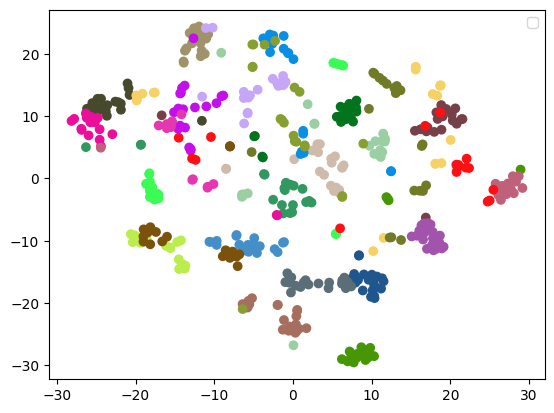

In [116]:
plt.scatter(res[:, 0], res[:, 1], c=cls_color[yy.numpy()],)
plt.legend()

In [117]:
from torchmetrics.functional import pairwise_cosine_similarity

In [118]:
d = pairwise_cosine_similarity(cls_embs,embs)

In [119]:
yy[d.argsort()][:40, -20:]

tensor([[212, 202, 202, 212, 200, 200, 200, 202, 200, 202, 200, 200, 200, 200,
         200, 200, 200, 200, 200, 200],
        [201, 201, 214, 201, 203, 204, 201, 203, 202, 203, 202, 203, 212, 201,
         201, 201, 201, 209, 201, 201],
        [200, 222, 211, 209, 214, 200, 202, 211, 202, 200, 202, 200, 200, 200,
         200, 202, 202, 200, 202, 202],
        [205, 224, 224, 203, 217, 218, 217, 217, 217, 217, 217, 217, 203, 217,
         203, 217, 203, 203, 203, 203],
        [207, 225, 204, 209, 223, 216, 206, 216, 216, 204, 216, 216, 223, 204,
         223, 206, 204, 204, 204, 204],
        [205, 224, 203, 204, 203, 203, 209, 223, 209, 204, 204, 204, 203, 224,
         204, 204, 204, 205, 205, 205],
        [216, 206, 216, 216, 216, 223, 218, 204, 223, 212, 223, 223, 212, 204,
         204, 206, 206, 206, 206, 206],
        [223, 224, 220, 220, 223, 207, 207, 220, 220, 207, 215, 215, 215, 220,
         207, 207, 207, 207, 207, 207],
        [211, 212, 211, 217, 206, 211, 211, 221,

<Axes: >

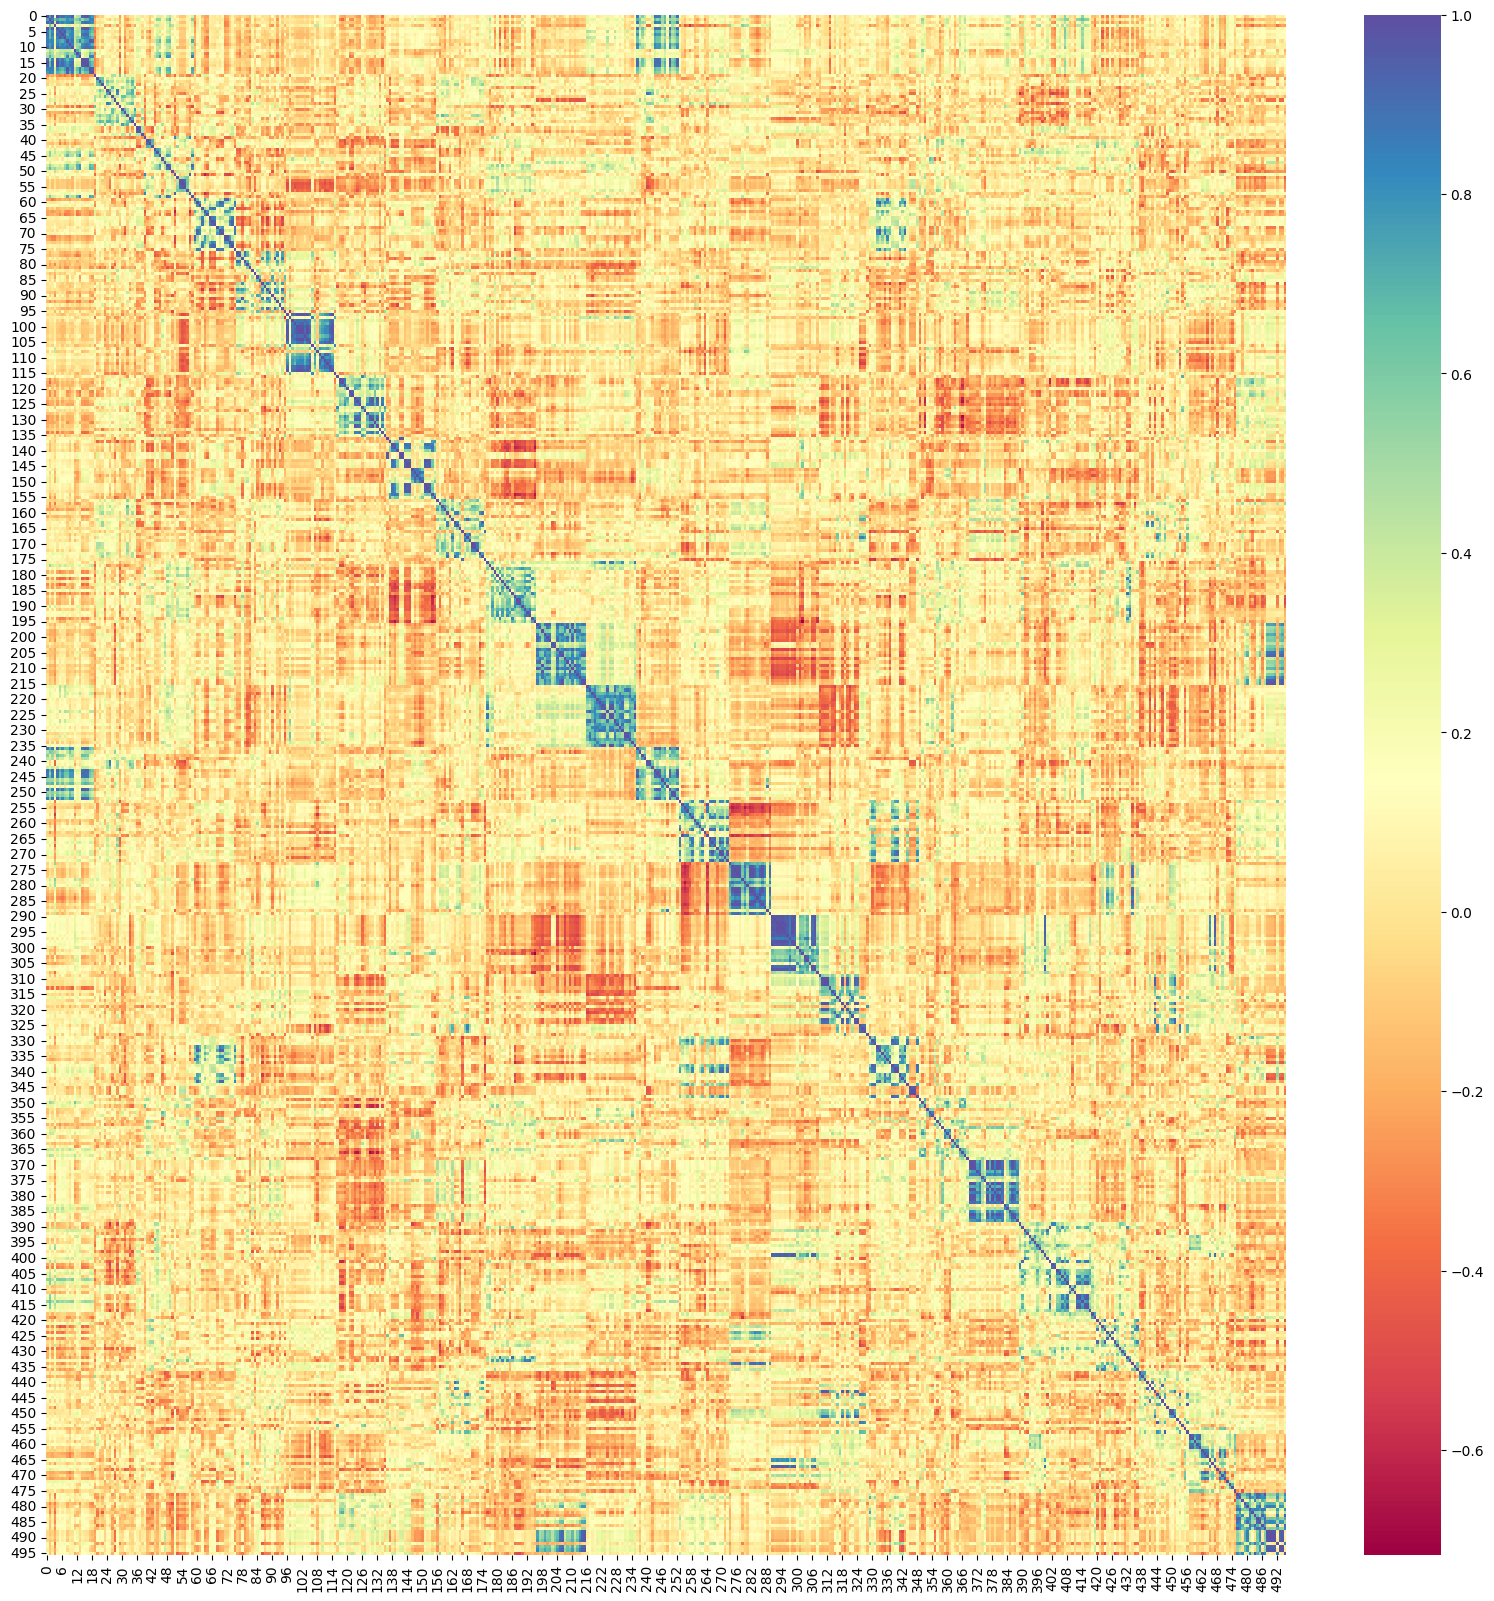

In [120]:
plt.figure(figsize=(20,20))
sns.heatmap(pairwise_cosine_similarity(embs,embs), annot=False, cmap='Spectral')
# plt.savefig('train_conf_mat.png')

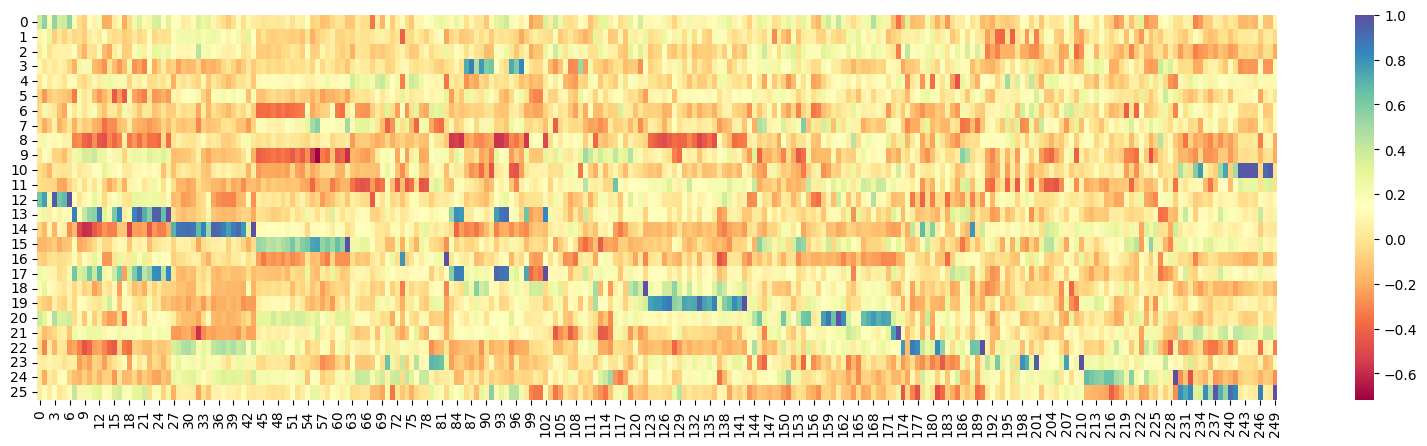

In [132]:
plt.figure(figsize=(20,5))
sns.heatmap(d[:, -250:], annot=False, cmap='Spectral')
plt.savefig('train_conf_mat.png')

In [133]:
d.argsort(dim=0)

tensor([[22, 21, 21,  ...,  3,  3, 22],
        [21,  7, 22,  ..., 16, 16, 24],
        [14, 15, 15,  ..., 23,  0,  8],
        ...,
        [20, 20, 20,  ..., 11, 11, 13],
        [ 0,  2,  0,  ..., 21, 21, 21],
        [12,  0, 12,  ..., 10, 10, 25]])

In [134]:
mask = torch.ones(len(yy))
mask[torch.tensor(list({cls: i for i, cls in enumerate(yy.numpy())}.values()))] = 0
mask = mask.bool()
# print(mask.long())
# mask26 = mask.clone()
# mask26[yy<200] = 0

In [135]:
yy.argsort()

tensor([  1,   0,  18,  17,  16,  15,  14,  13,  12,  11,   9,   8,   7,   6,
          5,   4,   3,   2,  10,  29,  30,  31,  32,  33,  35,  36,  37,  38,
         34,  27,  28,  20,  21,  22,  23,  19,  24,  25,  26,  58,  57,  56,
         55,  54,  53,  52,  51,  50,  48,  47,  39,  40,  41,  42,  43,  44,
         45,  46,  49,  63,  75,  74,  73,  72,  71,  70,  69,  68,  66,  65,
         64,  59,  62,  61,  60,  67,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  84,  83,  82,  81,  80,  79,  78,  77,  85,  76, 115, 107,
        108, 109, 110, 111, 112, 113, 114,  97, 105, 104, 103, 102, 101, 100,
         99,  98,  96, 106, 127, 128, 129, 130, 131, 132, 133, 134, 135, 122,
        125, 126, 117, 118, 119, 120, 116, 123, 124, 121, 149, 155, 154, 153,
        152, 151, 150, 148, 147, 146, 144, 143, 145, 142, 141, 140, 139, 138,
        137, 136, 167, 168, 169, 170, 171, 172, 173, 174, 175, 159, 165, 164,
        163, 162, 161, 160, 158, 157, 156, 166, 185, 187, 188, 1

In [136]:
# mask26

In [137]:
top1 = MulticlassAccuracy(yy.max().item() + 1 - 200, top_k=1)
top1(d.T[mask] - 200, yy[mask] - 200)

tensor(0.5007)

In [138]:
top5 = MulticlassAccuracy(yy.max().item() + 1 -200, top_k=5)
top5(d.T[mask] -200, yy[mask] - 200)

tensor(0.7532)

In [139]:
top10 = MulticlassAccuracy(yy.max().item() + 1-200, top_k=10)
top10(d.T[mask]-200, yy[mask]-200)

tensor(0.8597)

In [140]:
roc_auc = MulticlassAUROC(26)
roc_auc(d.T[mask]-200, yy[mask]-200)

tensor(0.8754)

In [141]:
mask.long()[:100:]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1])

In [143]:
from collections import defaultdict
avg = defaultdict(list)

for cls in tqdm(set(yy.numpy())):
    dd = d[cls-200, mask]
    # print(dd.shape)
    for c,b in zip(yy[mask].numpy(), dd.numpy()):
        avg[(cls, c)].append(b)

  0%|          | 0/26 [00:00<?, ?it/s]

In [144]:
avg = {k: np.mean(v) for k,v in avg.items()}

In [145]:
d.shape, yy.shape

(torch.Size([26, 496]), torch.Size([496]))

In [146]:
[(i, avg[(67,i)]) for i in set(yy.numpy()) if i < 200]

[]

In [147]:
np.min([i for i in avg.values()])

-0.3935615

<Axes: >

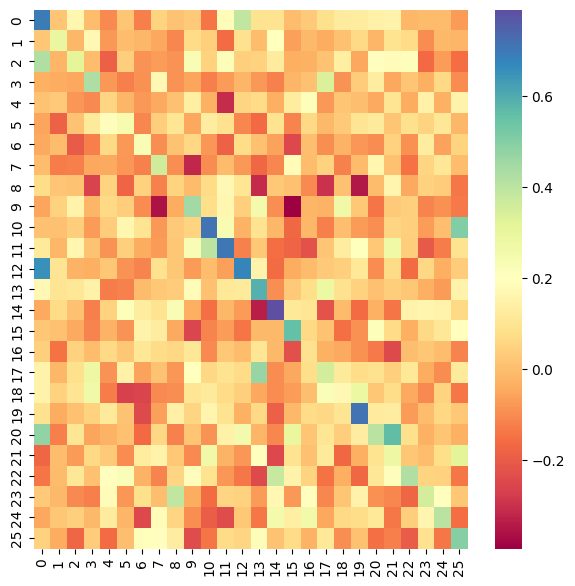

In [149]:
avg_pwcls_dist = np.zeros((26, 26))
for (a, b), v in avg.items():
    avg_pwcls_dist[a-200, b-200] = v

plt.figure(figsize=(7,7))
sns.heatmap(avg_pwcls_dist, annot=False, cmap='Spectral')
# plt.savefig('train_conf_mat.png')